In [1]:
import numpy as np
import pandas as pd
import time
import random
np.random.seed(2)  # reproducible

env_list=[]#['R','R','B','Y','Y','R','R','B','Y','Y']
N_STATES = 4 #number of balls  #7   # the length of the 1 dimensional world
ACTIONS = ['1','2','3','4','12','13','14','23','24','34'] #number of binrs    # available actions
EPSILON = 0.9   # greedy police
ALPHA = 0.1     # learning rate
GAMMA = 0.9    # discount factor
MAX_EPISODES = 5000  # maximum episodes
FRESH_TIME = 0.3    # fresh time for one move

OPEN_TIME=20
NUMBER_LANES=4

class Lanes:
    vehiclesinlane=np.random.randint(100)#40
    incoming=np.random.rand()#0.2
    out=np.random.rand()+1.0
    last=0

lanes=[]
for i in range(0,NUMBER_LANES):
    l=Lanes()
    print(i)
    lanes.append(l)


0
1
2
3


In [2]:
def genlist():
    global env_list
    env_list=lanes

In [3]:
def build_q_table(n_states, actions):
    table = pd.DataFrame(
        np.zeros((n_states, len(actions))),     # q_table initial values
        columns=actions,    # actions's name
    )
    # print(table)    # show table
    return table


In [4]:

def choose_action(state, q_table):
    # This is how to choose an action
    state_actions = q_table.iloc[state, :]
    if (np.random.uniform() > EPSILON) or ((state_actions == 0).all()):  # act non-greedy or state-action have no value
        action_name = np.random.choice(ACTIONS)
    else:   # act greedy
        action_name = state_actions.idxmax()    # replace argmax to idxmax as argmax means a different function in newer version of pandas
    return action_name


In [5]:
def display():
    global lanes
    print( "Lane1: "+str(int(lanes[0].vehiclesinlane))+ " Lane2: "+str(int(lanes[1].vehiclesinlane))+ 
          " Lane3: "+str(int(lanes[2].vehiclesinlane))+ " Lane4:"+str(int(lanes[3].vehiclesinlane)))


In [6]:
def reward(openn):
    global lanes
    penalty=0
    current=lanes[openn-1]
    otherlanes=[]
    for x in range(0,NUMBER_LANES):
        if x==openn-1:
            pass
        else:
            otherlanes.append(lanes[x])
    
    numcarsgo=min(current.out*OPEN_TIME,current.vehiclesinlane)
    
    current.vehiclesinlane-=numcarsgo
    #make change to current lane.
    penalty_thru=numcarsgo*(numcarsgo+1)/2
    penalty_stag_thru=current.vehiclesinlane
    curr_income=current.incoming*OPEN_TIME
    penalty_curr_incom=curr_income*(curr_income+1)/2
    penalty_curr=penalty_curr_incom+penalty_stag_thru+penalty_thru
    current.vehiclesinlane+=current.incoming*OPEN_TIME
    current.last=0
    #make change to other lanes.
    penalty_other=0
    for i in range(0,len(otherlanes)):
        x=otherlanes[i]
        penalty_other_stag=x.vehiclesinlane*OPEN_TIME*x.last
        other_incom=x.incoming*OPEN_TIME
        penalty_other_incom=other_incom*(other_incom+1)/2
        penalty_other+=penalty_other_incom+penalty_other_stag
        x.last+=0.5
        x.vehiclesinlane+=x.incoming*OPEN_TIME
    #get array back to store into lanes.
    ret=[]
    j=0
    for i in range(0,NUMBER_LANES):
        if i==openn-1:
            #print("current added")
            ret.append(current)
        else:
            #print(j)
            ret.append(otherlanes[j])
            j+=1
    #print(ret)
    lanes=ret
    total_penalty=penalty_other+penalty_curr
    
    return (-1)*total_penalty


In [7]:
plotrr=[]
signals=[]
def get_env_feedback(S, A):
    global env_list
    # This is how agent will interact with the environment
    disp=env_list[S]
    display()
    signals.append(A)
    if A == '1':
        lane=1
        print("opened lane now is:"+str(lane))
        R=reward(lane)
    elif A=='2':
        lane=2
        print("opened lane now is:"+str(lane))
        R=reward(lane)
    elif A=='3':
        lane=3
        print("opened lane now is:"+str(lane))
        R=reward(lane)
    elif A=='4':
        lane=4
        print("opened lane now is:"+str(lane))
        R=reward(lane)
    elif A=='12':
        R=-1000000
        print("clogged")
    elif A=='13':
        lane=1
        print("opened lane now is:"+str(lane))
        R=reward(lane)
        lane=3
        print("and "+str(lane))
        R+=reward(lane)
    elif A=='14':
        R=-1000000
    elif A=='23':
        R=-1000000
    elif A=='24':
        lane=2
        print("opened lane now is:"+str(lane))
        R=reward(lane)
        lane=4
        print("and "+str(lane))
        R+=reward(lane)
    elif A=='34':
        R=-1000000
    
    if S == N_STATES - 1:   # terminate
            S_ = 'terminal'
    else:
        S_=S+1
    plotrr.append(R)  
    return S_, R


In [8]:
def update_env(S, episode, step_counter):
    # This is how environment be updated
    
    global env_list
    #env_list = ['-']*(N_STATES-1) + ['T']   # '---------T' our environment
    
    if S == 'terminal':
        interaction = 'Episode %s: total_steps = %s' % (episode+1, step_counter)
        #print('\r{}'.format(interaction), end='')
        time.sleep(2)
        print('\r                                ', end='')
    else:
        
        #interaction = ''.join(env_list)
        #print('\r{}'.format(interaction), end='')
        time.sleep(FRESH_TIME)


In [9]:
def rl():
    # main part of RL loop
    q_table = build_q_table(N_STATES, ACTIONS)
    for episode in range(MAX_EPISODES):
        print(episode)
        genlist()
        step_counter = 0
        S = 0
        is_terminated = False
        update_env(S, episode, step_counter)
        while not is_terminated:
            
            
            A = choose_action(S, q_table)
            S_, R = get_env_feedback(S, A)  # take action & get next state and reward
            q_predict = q_table.loc[S, A]
            if S_ != 'terminal':
                q_target = R + GAMMA * q_table.iloc[S_, :].max()   # next state is not terminal
            else:
                q_target = R     # next state is terminal
                is_terminated = True    # terminate this episode

            q_table.loc[S, A] += ALPHA * (q_target - q_predict)  # update
            S = S_  # move to next state

            update_env(S, episode, step_counter+1)
            step_counter += 1
    return q_table

In [10]:

if __name__ == "__main__":
    q_table = rl()
    print('\r\nQ-table:\n')
    print(q_table)

0
Lane1: 40 Lane2: 40 Lane3: 40 Lane4:40
opened lane now is:2
and 4
Lane1: 47 Lane2: 8 Lane3: 47 Lane4:8
opened lane now is:2
Lane1: 51 Lane2: 3 Lane3: 51 Lane4:12
opened lane now is:1
and 3
Lane1: 19 Lane2: 11 Lane3: 19 Lane4:19
clogged
                                1
Lane1: 19 Lane2: 11 Lane3: 19 Lane4:19
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 23 Lane4:23
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 27 Lane4:27
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 30 Lane4:30
opened lane now is:1
                                2
Lane1: 3 Lane2: 25 Lane3: 34 Lane4:34
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 38 Lane4:38
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:42
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:45
opened lane now is:2
                                3
Lane1: 18 Lane2: 3 Lane3: 11 Lane4:49
opened lane now is:3
Lane1: 22 Lane2: 7 Lane3: 3 Lane4:53
opened lane now is:4
Lane1: 25 Lane2: 11 Lane3: 7 Lane4:18
opened lane now is:3
Lane1: 29 Lane

Lane1: 18 Lane2: 3 Lane3: 7 Lane4:22
opened lane now is:4
Lane1: 22 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:2
                                32
Lane1: 25 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:2
Lane1: 29 Lane2: 3 Lane3: 18 Lane4:11
opened lane now is:3
Lane1: 33 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
Lane1: 37 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:2
and 4
                                33
Lane1: 44 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 48 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:4
Lane1: 51 Lane2: 14 Lane3: 7 Lane4:3
opened lane now is:2
Lane1: 55 Lane2: 3 Lane3: 11 Lane4:7
opened lane now is:4
                                34
Lane1: 59 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:1
Lane1: 24 Lane2: 11 Lane3: 18 Lane4:7
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 7 Lane4:18
opened lane now is:3
                                35
Lane1: 7 Lane2: 25 Lane3: 3 Lane4:

Lane1: 7 Lane2: 37 Lane3: 3 Lane4:22
opened lane now is:1
                                62
Lane1: 3 Lane2: 40 Lane3: 7 Lane4:26
opened lane now is:2
and 4
Lane1: 11 Lane2: 9 Lane3: 14 Lane4:3
opened lane now is:4
Lane1: 14 Lane2: 13 Lane3: 18 Lane4:3
opened lane now is:2
and 4
Lane1: 22 Lane2: 7 Lane3: 25 Lane4:3
opened lane now is:2
and 4
                                63
Lane1: 29 Lane2: 7 Lane3: 33 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:4
Lane1: 11 Lane2: 18 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 11 Lane4:7
opened lane now is:1
                                64
Lane1: 3 Lane2: 25 Lane3: 14 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 29 Lane3: 18 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 33 Lane3: 3 Lane4:7
Lane1: 11 Lane2: 33 Lane3: 3 Lane4:7
opened lane now is:1
                                65
Lane1: 3 Lane2: 37 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 40 Lane3: 11 Lane4:14
opene

Lane1: 25 Lane2: 3 Lane3: 18 Lane4:11
opened lane now is:4
Lane1: 29 Lane2: 7 Lane3: 22 Lane4:3
opened lane now is:4
Lane1: 33 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:2
                                93
Lane1: 37 Lane2: 3 Lane3: 29 Lane4:7
opened lane now is:4
Lane1: 40 Lane2: 7 Lane3: 33 Lane4:3
opened lane now is:3
Lane1: 44 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:3
Lane1: 48 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:2
                                94
Lane1: 51 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:3
Lane1: 55 Lane2: 7 Lane3: 3 Lane4:18
opened lane now is:3
Lane1: 59 Lane2: 11 Lane3: 3 Lane4:22
opened lane now is:1
Lane1: 24 Lane2: 14 Lane3: 7 Lane4:25
opened lane now is:1
                                95
Lane1: 3 Lane2: 18 Lane3: 11 Lane4:29
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:33
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 18 Lane4:37
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 22 Lane4:3
opened lane now is:1
                   

Lane1: 3 Lane2: 7 Lane3: 14 Lane4:48
opened lane now is:1
                                123
Lane1: 3 Lane2: 11 Lane3: 18 Lane4:51
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 22 Lane4:16
opened lane now is:4
Lane1: 11 Lane2: 18 Lane3: 25 Lane4:3
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 29 Lane4:7
opened lane now is:2
                                124
Lane1: 18 Lane2: 3 Lane3: 33 Lane4:11
opened lane now is:1
and 3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 7 Lane4:22
opened lane now is:4
Lane1: 7 Lane2: 18 Lane3: 11 Lane4:3
opened lane now is:2
                                125
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:4
Lane1: 14 Lane2: 7 Lane3: 18 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 22 Lane4:7
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 25 Lane4:3
opened lane now is:2
                                126
Lane1: 11 Lane2: 3 Lane3: 29 Lane4:7
opened lane now is:4
Lane1: 14 Lane2: 7 Lane3: 33 Lane4

Lane1: 14 Lane2: 51 Lane3: 18 Lane4:3
opened lane now is:2
and 4
Lane1: 22 Lane2: 20 Lane3: 25 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 27 Lane3: 3 Lane4:11
opened lane now is:1
                                154
Lane1: 3 Lane2: 31 Lane3: 7 Lane4:14
opened lane now is:1
and 3
Lane1: 7 Lane2: 39 Lane3: 3 Lane4:22
opened lane now is:2
Lane1: 11 Lane2: 4 Lane3: 7 Lane4:25
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:29
                                155
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:29
opened lane now is:3
Lane1: 18 Lane2: 11 Lane3: 3 Lane4:33
opened lane now is:3
Lane1: 22 Lane2: 15 Lane3: 3 Lane4:37
opened lane now is:3
Lane1: 25 Lane2: 18 Lane3: 3 Lane4:40
opened lane now is:1
                                156
Lane1: 3 Lane2: 22 Lane3: 7 Lane4:44
opened lane now is:1
Lane1: 3 Lane2: 26 Lane3: 11 Lane4:48
clogged
Lane1: 3 Lane2: 26 Lane3: 11 Lane4:48
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:51
opened lane now is:1
                               

                                184
Lane1: 7 Lane2: 70 Lane3: 3 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 74 Lane3: 3 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 77 Lane3: 7 Lane4:18
opened lane now is:1
Lane1: 3 Lane2: 81 Lane3: 11 Lane4:22
opened lane now is:3
                                185
Lane1: 7 Lane2: 85 Lane3: 3 Lane4:25
opened lane now is:1
and 3
Lane1: 7 Lane2: 92 Lane3: 3 Lane4:33
opened lane now is:2
Lane1: 11 Lane2: 57 Lane3: 7 Lane4:37
opened lane now is:2
and 4
Lane1: 18 Lane2: 26 Lane3: 14 Lane4:5
opened lane now is:2
and 4
                                186
Lane1: 25 Lane2: 7 Lane3: 22 Lane4:3
opened lane now is:2
and 4
Lane1: 33 Lane2: 7 Lane3: 29 Lane4:3
opened lane now is:2
Lane1: 37 Lane2: 3 Lane3: 33 Lane4:7
opened lane now is:4
Lane1: 40 Lane2: 7 Lane3: 37 Lane4:3
opened lane now is:2
and 4
                                187
Lane1: 48 Lane2: 7 Lane3: 44 Lane4:3
opened lane now is:4
Lane1: 51 Lane2: 11 Lane3: 48 Lane4:3
opened lane now is:3
Lane1: 55

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                215
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                216
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 14 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:4
Lane1: 18 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                217
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                        

Lane1: 7 Lane2: 22 Lane3: 3 Lane4:11
clogged
                                245
Lane1: 7 Lane2: 22 Lane3: 3 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 25 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 29 Lane3: 11 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 37 Lane3: 3 Lane4:11
opened lane now is:2
                                246
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                247
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:25
opened lane now is:2
                                248
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:29
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:33
opened lane now is:4
La

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                276
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                277
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:22
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:29
opened lane now is:2
                                278
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:33
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:37
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:

Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                306
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                307
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 14 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:2
                                308
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                309
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lan

Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                337
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                338
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 14 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:4
Lane1: 18 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                339
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and

Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                367
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                368
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                369
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                397
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 14 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:2
                                398
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 14 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:2
                                399
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                400
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
and 

Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                427
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:25
opened lane now is:2
                                428
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:29
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:33
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                429
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:2
and 4
Lane1: 11 Lane2: 7 Lane3: 18 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:2
                                430
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
open

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                458
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                459
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:2
and 4
Lane1: 11 Lane2: 7 Lane3: 18 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:2
                                460
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
clogged
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
           

Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                488
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                489
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:1
and 3
                                490
Lane1: 7 Lane2: 25 Lane3: 3 Lane4:18
opened lane now is:1
Lane1: 3 Lane2: 29 Lane3: 7 Lane4:22
opened lane now is:4
Lane1: 7 Lane2: 33 Lane3: 11 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 40 Lane3: 3 Lane4:11
opened lane now is:2
                                491
Lane1: 11 Lane2: 5 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 9 La

                                518
Lane1: 7 Lane2: 27 Lane3: 3 Lane4:18
opened lane now is:1
Lane1: 3 Lane2: 31 Lane3: 7 Lane4:22
opened lane now is:4
Lane1: 7 Lane2: 35 Lane3: 11 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 42 Lane3: 3 Lane4:11
opened lane now is:2
                                519
Lane1: 11 Lane2: 7 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 15 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 22 Lane3: 3 Lane4:11
opened lane now is:2
                                520
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
clogged
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
and 3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:22
opened lane now is:3
                                521
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:25
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:29
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:1


Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                549
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                550
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                551
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:

Lane1: 7 Lane2: 22 Lane3: 3 Lane4:11
opened lane now is:2
                                579
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                580
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                581
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                582
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 1

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:2
and 4
Lane1: 11 Lane2: 7 Lane3: 18 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:2
                                610
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                611
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 14 Lane2: 7 Lane3: 11 Lane4:3
Lane1: 14 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:2
                                612
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
             

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                640
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 14 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:4
Lane1: 18 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                641
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                642
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
clogged
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                643
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
o

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                670
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:25
                                671
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:25
opened lane now is:1
and 3
Lane1: 7 Lane2: 22 Lane3: 3 Lane4:33
opened lane now is:4
Lane1: 11 Lane2: 25 Lane3: 7 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 33 Lane3: 3 Lane4:11
opened lane now is:2
                                672
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                673
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:

                                700
Lane1: 14 Lane2: 3 Lane3: 22 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 25 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 29 Lane4:3
Lane1: 7 Lane2: 11 Lane3: 29 Lane4:3
                                701
Lane1: 7 Lane2: 11 Lane3: 29 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:4
Lane1: 11 Lane2: 22 Lane3: 7 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 29 Lane3: 3 Lane4:11
opened lane now is:2
                                702
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                703
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 14 Lane4:22
opened lane now is:1
and 3
La

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                731
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                732
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                733
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                734
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lan

Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                761
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                762
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
                                763
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 11 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 33 Lane3: 3 Lane4:11
                                764
Lane1: 7 Lane2: 33 Lane3: 3 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 37 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 L

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
                                792
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 11 Lane4:3
Lane1: 7 Lane2: 25 Lane3: 11 Lane4:3
opened lane now is:2
                                793
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 18 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 22 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                794
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
clogged
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
and 3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:22
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:29
opened lane now is:2
                                795
Lane1: 11 Lane2: 

Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                822
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                823
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                824
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                825
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 1

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
                                853
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
                                854
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
                                855
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
      

Lane1: 14 Lane2: 3 Lane3: 22 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 25 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 29 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                884
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                885
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                886
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 L

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                914
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                915
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                916
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:3
Lane1: 18 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
Lane1: 22 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:3
Lane1: 25 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                917
Lane1: 29 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened 

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                945
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
                                946
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 29 Lane3: 3 Lane4:7
opened lane now is:2
                                947
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                948
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                976
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                977
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                978
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                      

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1007
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1008
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
clogged
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
                                1009
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 18 Lane4:7
opened lane now is:4
Lane1: 7 Lane2: 18 Lane3: 22 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 22 Lane3: 3 Lane4:7
opened lane now 

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1037
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1038
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1039
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1040
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
ope

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
clogged
                                1068
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
                                1069
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1070
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1071
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now 

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                1099
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:14
opened lane now is:2
                                1100
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:18
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:22
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1101
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1102
Lane1: 14 Lane2: 3 Lane3

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1130
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1131
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 22 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:2
                                1132
Lane1: 25 Lane2: 3 Lane3: 18 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
op

                                1160
Lane1: 14 Lane2: 5 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 9 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 13 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 16 Lane3: 3 Lane4:7
opened lane now is:2
                                1161
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1162
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1163
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:2
and 4
Lane1: 11 Lane2: 7 Lane3: 18 Lane4

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1191
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
                                1192
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
                                1193
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1194
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lan

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1222
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:2
and 4
Lane1: 22 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:4
Lane1: 25 Lane2: 11 Lane3: 18 Lane4:3
opened lane now is:3
Lane1: 29 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1223
Lane1: 33 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
and 3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:4
Lane1: 11 Lane2: 14 Lane3: 7 Lane4:3
opened lane now is:3
Lane1: 14 Lane2: 18 Lane3: 3 Lane4:7
opened lane now is:2
                                1224
Lane1: 18 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1225
Lane1: 14 Lane2: 3 Lane3: 7

Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
                                1253
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
                                1254
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
                                1255
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 29 Lane3: 3 Lane4:7
opened lane now is:2
                                1256
La

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1284
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1285
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1286
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                   

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1315
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1316
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1317
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1345
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
clogged
                                1346
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
                                1347
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1348
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now 

Lane1: 11 Lane2: 7 Lane3: 3 Lane4:22
opened lane now is:2
                                1376
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:25
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:29
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1377
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 14 Lane4:18
opened lane now is:3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:22
opened lane now is:2
                                1378
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:25
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:29
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1379
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
op

Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
                                1407
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1408
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1409
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1410
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
ope

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                1438
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
and 3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:14
opened lane now is:4
Lane1: 11 Lane2: 14 Lane3: 7 Lane4:3
opened lane now is:3
Lane1: 14 Lane2: 18 Lane3: 3 Lane4:7
opened lane now is:2
                                1439
Lane1: 18 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                1440
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is

                                1468
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1469
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1470
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1471
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
ope

                                1499
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1500
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:4
                                1501
Lane1: 14 Lane2: 18 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 11 Lane4:7
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 29 Lane3: 3 Lane4:7
opened lane now is:2
                                1502
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:4
Lane1: 22 Lane2: 11 Lane3: 14 Lane4:3
op

Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                1530
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1531
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1532
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1533
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
ope

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1561
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:4
Lane1: 11 Lane2: 14 Lane3: 18 Lane4:3
opened lane now is:2
                                1562
Lane1: 14 Lane2: 3 Lane3: 22 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 25 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 29 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1563
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
clogged
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
                               

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1592
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1593
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
                                1594
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 18 Lane4:7
opened lane now is:4
Lane1: 7 Lane2: 18 Lane3: 22 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 22 Lane3: 3 Lane4:7
opened lane now is:3
                                1595
Lane1: 14 Lane2: 25 Lane

Lane1: 29 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:3
                                1623
Lane1: 14 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 29 Lane3: 3 Lane4:7
opened lane now is:2
                                1624
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:3
Lane1: 18 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
Lane1: 22 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:3
Lane1: 25 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1625
Lane1: 29 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 1

                                1653
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:2
                                1654
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:22
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:25
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1655
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1656
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lan

                                1684
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
clogged
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:2
and 4
Lane1: 22 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 25 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
                                1685
Lane1: 29 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1686
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1687
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:2
Lane1: 18 Lane2: 3 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 22 Lane2: 7 Lane3: 14 Lane4:3
opened la

Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
                                1715
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1716
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1717
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1718
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
ope

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1746
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1747
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1748
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                   

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1777
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1778
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:2
                                1779
Lane1: 14 Lane2: 3 Lane3: 22 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 25 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 29 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                  

                                1807
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
clogged
                                1808
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
                                1809
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1810
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now 

                                1838
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
clogged
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                1839
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:14
opened lane now is:2
                                1840
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:18
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:22
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1841
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:2
Lane1: 18 Lane2: 3 Lane3: 11 Lane4:14
Lane1: 18 Lane2: 3 Lane3: 11 Lane4:14
opened lane now is:3
Lane1: 22 Lane2: 7 Lane3: 3 Lane4:1

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1869
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 18 Lane4:7
opened lane now is:2
                                1870
Lane1: 7 Lane2: 3 Lane3: 22 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 25 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 29 Lane4:3
opened lane now is:2
and 4
Lane1: 14 Lane2: 7 Lane3: 37 Lane4:3
opened lane now is:2
                                1871
Lane1: 18 Lane2: 3 Lane3: 40 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 44 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 48 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 13 Lane4:7
opened lane now is:1
and 3
                                1872
Lane1: 7 Lane2: 22 Lane3: 3 Lane4:14
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1900
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:4
                                1901
Lane1: 14 Lane2: 18 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 11 Lane4:7
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 29 Lane3: 3 Lane4:7
opened lane now is:2
                                1902
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1903
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lan

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1931
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1932
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:2
and 4
Lane1: 22 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:4
Lane1: 25 Lane2: 11 Lane3: 18 Lane4:3
opened lane now is:3
Lane1: 29 Lane2: 14 Lane3: 3 Lane4:7
                                1933
Lane1: 29 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
                                1934
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 2

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1962
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1963
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1964
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:2
and 4
Lane1: 22 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:4
Lane1: 25 Lane2: 11 Lane3: 18 Lane4:3
opened lane now is:3
Lane1: 29 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1965
Lane1: 33 Lane2: 3 Lane3: 7 Lane4

Lane1: 37 Lane2: 3 Lane3: 29 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 33 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 37 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1993
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                1994
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:2
                                1995
Lane1: 14 Lane2: 3 Lane3: 22 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 25 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 29 Lane4:3
clogged
Lane1: 7 Lane2: 11 Lane3: 29 La

                                2023
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2024
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
clogged
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                2025
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2026
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 22 Lane2:

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
and 3
                                2054
Lane1: 7 Lane2: 22 Lane3: 3 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 25 Lane3: 7 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 29 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 33 Lane3: 3 Lane4:7
opened lane now is:2
                                2055
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2056
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2057
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2085
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:22
opened lane now is:2
                                2086
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:25
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:29
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2087
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:2
                                2088
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:22
opened lane now is:1
La

Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
                                2116
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2117
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2118
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2119
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
ope

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2147
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2148
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2149
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                2150
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lan

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2178
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2179
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2180
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
and 4
                                2181
Lane1: 18 Lane2: 7 Lane3: 11 Lane4

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2209
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2210
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
and 3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:4
Lane1: 11 Lane2: 14 Lane3: 7 Lane4:3
opened lane now is:3
Lane1: 14 Lane2: 18 Lane3: 3 Lane4:7
opened lane now is:2
                                2211
Lane1: 18 Lane2: 3 Lane3: 7 Lane4:11
clogged
Lane1: 18 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 22 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 25 Lane2: 11 Lane3:

                                2239
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2240
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:2
                                2241
Lane1: 14 Lane2: 3 Lane3: 22 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 22 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 25 Lane4:3
opened lane now is:3
Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
                                2242
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
L

                                2270
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:29
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:33
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
                                2271
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:18
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2272
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2273
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4

Lane1: 22 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:3
Lane1: 25 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2301
Lane1: 29 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2302
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2303
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2304
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
ope

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2332
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
clogged
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                2333
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:2
                                2334
Lane1: 11 Lane2: 3 Lane3: 29 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 33 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 37 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now 

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:37
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2363
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2364
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2365
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                   

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2394
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2395
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2396
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
                                2397
Lan

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2425
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2426
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2427
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:2
                                2428
Lan

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2456
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2457
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2458
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                   

                                2486
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2487
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2488
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2489
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
ope

Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:2
                                2517
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:22
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:25
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:25
opened lane now is:3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:29
opened lane now is:2
                                2518
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:33
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:37
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2519
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2520
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lan

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2548
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2549
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2550
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                   

                                2578
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
and 4
Lane1: 14 Lane2: 7 Lane3: 22 Lane4:3
opened lane now is:2
                                2579
Lane1: 18 Lane2: 3 Lane3: 25 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 29 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 33 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2580
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
clogged
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                2581
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lan

                                2609
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2610
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
and 3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:4
Lane1: 11 Lane2: 14 Lane3: 7 Lane4:3
opened lane now is:3
Lane1: 14 Lane2: 18 Lane3: 3 Lane4:7
opened lane now is:3
                                2611
Lane1: 18 Lane2: 22 Lane3: 3 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 25 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 29 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 33 Lane3: 3 Lane4:7
opened lane now is:2
                                2612
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now i

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2640
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2641
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2642
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2643
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
ope

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2671
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
clogged
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                2672
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2673
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2702
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:2
and 4
Lane1: 22 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:4
Lane1: 25 Lane2: 11 Lane3: 18 Lane4:3
opened lane now is:3
Lane1: 29 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2703
Lane1: 33 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2704
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
clogged
Lane1: 7 Lane2: 11 Lane3:

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2733
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
                                2734
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
                                2735
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
ope

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
                                2763
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2764
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2765
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:2
                                2766
Lane1: 14 Lane2: 3 Lane3: 22 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 25 Lane4:14
op

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:2
                                2794
Lane1: 14 Lane2: 3 Lane3: 22 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 25 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 29 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2795
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
                                2796
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:4
                                2797
La

Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
                                2825
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2826
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:4
Lane1: 22 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 25 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2827
Lane1: 29 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2828
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
op

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2856
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2857
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2858
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane

                                2886
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2887
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
                                2888
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:2
and 4
Lane1: 33 Lane2: 7 Lane3: 14 Lane4:3
Lane1: 33 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 37 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
                                2889
Lane1: 40 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 5 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 9 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 13 Lane2: 1

                                2917
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:4
Lane1: 11 Lane2: 14 Lane3: 18 Lane4:3
opened lane now is:2
                                2918
Lane1: 14 Lane2: 3 Lane3: 22 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 25 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 29 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2919
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2920
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
op

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2948
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2949
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
                                2950
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
                                2951
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:1
and 3
Lane1: 7 Lane2: 25 Lane3: 3 Lane4:

Lane1: 3 Lane2: 66 Lane3: 7 Lane4:29
opened lane now is:1
Lane1: 3 Lane2: 70 Lane3: 11 Lane4:33
opened lane now is:2
                                2979
Lane1: 7 Lane2: 35 Lane3: 14 Lane4:37
opened lane now is:4
Lane1: 11 Lane2: 39 Lane3: 18 Lane4:3
opened lane now is:4
Lane1: 14 Lane2: 42 Lane3: 22 Lane4:3
opened lane now is:4
Lane1: 18 Lane2: 46 Lane3: 25 Lane4:3
opened lane now is:4
                                2980
Lane1: 22 Lane2: 50 Lane3: 29 Lane4:3
opened lane now is:4
Lane1: 25 Lane2: 53 Lane3: 33 Lane4:3
opened lane now is:4
Lane1: 29 Lane2: 57 Lane3: 37 Lane4:3
opened lane now is:4
Lane1: 33 Lane2: 61 Lane3: 40 Lane4:3
opened lane now is:1
                                2981
Lane1: 3 Lane2: 65 Lane3: 44 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 30 Lane3: 48 Lane4:11
opened lane now is:2
and 4
Lane1: 14 Lane2: 7 Lane3: 55 Lane4:3
opened lane now is:3
Lane1: 18 Lane2: 11 Lane3: 20 Lane4:7
opened lane now is:2
and 4
                                2982
Lane1: 25 Lane2: 

Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:4
Lane1: 7 Lane2: 18 Lane3: 14 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 22 Lane3: 3 Lane4:7
opened lane now is:4
                                3010
Lane1: 14 Lane2: 25 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 29 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3011
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3012
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                   

                                3040
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:2
and 4
Lane1: 22 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:2
Lane1: 25 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:2
Lane1: 29 Lane2: 3 Lane3: 22 Lane4:11
opened lane now is:4
                                3041
Lane1: 33 Lane2: 7 Lane3: 25 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 29 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 33 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3042
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3043
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4

Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:4
                                3071
Lane1: 11 Lane2: 7 Lane3: 18 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 22 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 25 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3072
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3073
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
and 4
Lane1: 11 Lane2: 7 Lane3: 18 Lane4:3
opened lane now is:2
and 4
Lane1: 18 Lane2: 7 Lane3: 25 Lane4:3
opened lane now is:4
                                3074
Lane1: 22 Lane2: 11 Lane3: 29 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 3

Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3102
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3103
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3104
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                   

Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3133
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3134
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3135
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 14 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:4
             

Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3164
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3165
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3166
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 

Lane1: 14 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 7 Lane4:22
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 11 Lane4:25
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:29
opened lane now is:4
                                3195
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3196
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3197
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
op

                                3225
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3226
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3227
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3228
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
ope

Lane1: 14 Lane2: 11 Lane3: 3 Lane4:7
clogged
                                3256
Lane1: 14 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 7 Lane4:11
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 11 Lane4:14
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:18
opened lane now is:4
                                3257
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:2
Lane1: 18 Lane2: 3 Lane3: 11 Lane4:7
clogged
Lane1: 18 Lane2: 3 Lane3: 11 Lane4:7
opened lane now is:4
                                3258
Lane1: 22 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 18 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 22 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3259
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 L

Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3287
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:3
Lane1: 18 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 22 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:3
Lane1: 25 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3288
Lane1: 29 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3289
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:4
Lane1: 7 Lane2: 18 Lane3: 14 Lane4:3
Lane1: 7 Lane2: 18 Lane3: 14 Lane4:3
opened lane now is:4
                                3290
Lane1: 11 Lane2: 22 Lane3: 18 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 25 Lane3: 22 Lane4:7
opened lane now is:2
La

Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3318
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3319
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:2
and 4
Lane1: 14 Lane2: 7 Lane3: 22 Lane4:3
opened lane now is:4
                                3320
Lane1: 18 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 29 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 33 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3321
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane

Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3349
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:4
                                3350
Lane1: 11 Lane2: 22 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 25 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
                                3351
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:18
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 11 Lane4:22
opened lane now is:4
Lane1: 11 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:4
                                3352
Lane1: 14 Lane2: 11 Lane3: 18 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane

Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3380
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 7 Lane2: 22 Lane3: 3 Lane4:14
opened lane now is:4
                                3381
Lane1: 11 Lane2: 25 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 29 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3382
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3383
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
op

Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3411
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 22 Lane3: 3 Lane4:14
opened lane now is:4
                                3412
Lane1: 14 Lane2: 25 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 29 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3413
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:4
Lane1: 11 Lane2: 7

Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3442
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:3
Lane1: 7 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:4
                                3443
Lane1: 11 Lane2: 22 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 25 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:4
Lane1: 11 Lane2: 7 Lane3: 18 Lane4:3
opened lane now is:4
                                3444
Lane1: 14 Lane2: 11 Lane3: 22 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 25 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 29 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
op

                                3472
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:22
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:25
opened lane now is:1
and 3
Lane1: 7 Lane2: 25 Lane3: 3 Lane4:33
opened lane now is:3
Lane1: 11 Lane2: 29 Lane3: 3 Lane4:37
opened lane now is:4
                                3473
Lane1: 14 Lane2: 33 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 37 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3474
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3475
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4

Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3503
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
clogged
                                3504
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:18
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 11 Lane4:22
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:25
opened lane now is:4
                                3505
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3506
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now 

Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:2
and 4
                                3534
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 14 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 18 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3535
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3536
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
             

                                3564
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3565
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:4
Lane1: 11 Lane2: 7 Lane3: 18 Lane4:3
opened lane now is:4
                                3566
Lane1: 14 Lane2: 11 Lane3: 22 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 25 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 29 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3567
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:2
and 4
Lane1: 22 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:2
Lane1: 25 Lane2: 3 Lane3: 18 Lane

Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3595
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3596
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3597
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3598
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
ope

Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3626
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3627
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3628
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:2
Lane1: 18 Lane2: 3 Lane3: 11 Lane4:7
opened lane now is:3
Lane1: 22 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:4
                                3629
Lane1: 25 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lan

Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3657
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3658
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3659
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                   

Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3688
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3689
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3690
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 

                                3718
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:1
and 3
                                3719
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:22
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:25
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 11 Lane4:29
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:33
opened lane now is:4
                                3720
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3721
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:

Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3749
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
                                3750
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:18
clogged
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:18
opened lane now is:3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:22
opened lane now is:4
                                3751
Lane1: 11 Lane2: 18 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3752
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:4
Lane1: 18 Lane2: 14 Lane3: 11 Lane4:3

Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3780
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:2
and 4
                                3781
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 14 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 18 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
                                3782
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:18
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 11 Lane4:22
Lane1: 7 Lane2: 3 Lane3: 11 Lane4:22
opened lane now is:4
                                3783
Lane1: 11 Lane2: 7 Lane3: 14 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 18 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 

Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3811
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3812
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3813
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3814
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
ope

Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3842
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3843
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3844
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:4
Lane1: 18 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 22 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 25 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:4
                                3845
Lane1: 29 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
op

Lane1: 37 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 40 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 44 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:4
                                3873
Lane1: 48 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 13 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 16 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 20 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3874
Lane1: 24 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 18 Lane4:14
opened lane now is:4
                                3875
Lane1: 7 Lane2: 11 Lane3: 22 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 25 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 29 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                

Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3904
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3905
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
                                3906
Lane1: 14 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 14 Lane3: 11 Lane4:7
opened lane now is:2
and 4
Lane1: 11 Lane2: 7 Lane3: 18 Lane4:3
opened lane now is:3
Lane1: 14 Lan

                                3934
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                3935
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                3936
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                3937
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
ope

                                3965
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 11 Lane4:3
opened lane now is:3
                                3966
Lane1: 11 Lane2: 29 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                3967
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
and 3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:4
Lane1: 11 Lane2: 14 Lane3: 7 Lane4:3
opened lane now is:3
                                3968
Lane1: 14 Lane2: 18 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 18 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4

Lane1: 7 Lane2: 33 Lane3: 11 Lane4:3
opened lane now is:3
                                3996
Lane1: 11 Lane2: 37 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                3997
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
clogged
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
and 3
Lane1: 7 Lane2: 22 Lane3: 3 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 25 Lane3: 7 Lane4:18
opened lane now is:3
                                3998
Lane1: 7 Lane2: 29 Lane3: 3 Lane4:22
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:25
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:29
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                3999
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lan

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:3
                                4027
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:22
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:25
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4028
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4029
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:3
Lane1: 18 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
Lane1: 22 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:3
                                4030
Lane1: 25 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lan

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4058
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4059
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:3
                                4060
Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 29 Lane2: 7 Lane3: 11 Lane4:3
                        

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
                                4089
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4090
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
                                4091
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
   

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
and 4
                                4120
Lane1: 14 Lane2: 7 Lane3: 22 Lane4:3
opened lane now is:2
Lane1: 18 Lane2: 3 Lane3: 25 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 29 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 33 Lane4:3
opened lane now is:3
                                4121
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4122
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane

                                4150
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4151
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4152
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4153
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
ope

                                4181
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:3
Lane1: 18 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
Lane1: 22 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:3
                                4182
Lane1: 25 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:4
Lane1: 29 Lane2: 18 Lane3: 7 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 11 Lane4:7
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 14 Lane4:3
opened lane now is:3
                                4183
Lane1: 11 Lane2: 29 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4184
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 22 Lane3: 11 Lane4:14
op

                                4212
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4213
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4214
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4215
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
ope

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4244
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4245
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4246
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 

                                4274
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:3
                                4275
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4276
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4277
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lan

Lane1: 14 Lane2: 7 Lane3: 22 Lane4:3
opened lane now is:3
                                4305
Lane1: 18 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 22 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4306
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4307
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4308
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
ope

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4336
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4337
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4338
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4339
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
ope

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:25
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:29
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4367
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:3
                                4368
Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4369
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4370
Lan

Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4398
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:3
                                4399
Lane1: 22 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 25 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4400
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
ope

Lane1: 14 Lane2: 18 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 18 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
and 4
                                4429
Lane1: 14 Lane2: 7 Lane3: 22 Lane4:3
opened lane now is:2
Lane1: 18 Lane2: 3 Lane3: 25 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 29 Lane4:11
Lane1: 3 Lane2: 7 Lane3: 29 Lane4:11
opened lane now is:1
                                4430
Lane1: 3 Lane2: 11 Lane3: 33 Lane4:14
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 37 Lane4:18
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 40 Lane4:22
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 44 Lane4:3
opened lane now is:3
                                4431
Lane1: 11 Lane2: 14 Lane3: 9 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 13 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 16 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 20 Lan

Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4459
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
                                4460
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:3
                                4461
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4462
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lan

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4490
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4491
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:1
Lane1: 3 Lane2: 11 Lane3: 14 Lane4:18
opened lane now is:3
                                4492
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:22
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:25
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:29
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4493
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
op

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:29
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4521
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
                                4522
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 18 Lane4:7
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:3
                                4523
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4524
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lan

Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4552
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4553
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:3
Lane1: 7 Lane2: 11 Lane3: 3 Lane4:18
opened lane now is:3
                                4554
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:22
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:25
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:29
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4555
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
op

Lane1: 14 Lane2: 3 Lane3: 7 Lane4:29
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:33
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4583
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4584
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 14 Lane4:3
opened lane now is:3
                                4585
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
Lane1: 11 Lane2: 14 Lane3: 3 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 7 Lane4:11
opened lane now is:3
                                4586
Lane1: 18 Lane2: 7 Lane3

Lane1: 29 Lane2: 3 Lane3: 22 Lane4:7
opened lane now is:4
Lane1: 33 Lane2: 7 Lane3: 25 Lane4:3
opened lane now is:2
Lane1: 37 Lane2: 3 Lane3: 29 Lane4:7
opened lane now is:4
Lane1: 40 Lane2: 7 Lane3: 33 Lane4:3
opened lane now is:2
                                4614
Lane1: 44 Lane2: 3 Lane3: 37 Lane4:7
opened lane now is:1
Lane1: 9 Lane2: 7 Lane3: 40 Lane4:11
opened lane now is:4
Lane1: 13 Lane2: 11 Lane3: 44 Lane4:3
opened lane now is:3
Lane1: 16 Lane2: 14 Lane3: 9 Lane4:7
opened lane now is:2
and 4
                                4615
Lane1: 24 Lane2: 7 Lane3: 16 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:1
and 3
Lane1: 7 Lane2: 22 Lane3: 3 Lane4:18
opened lane now is:3
Lane1: 11 Lane2: 25 Lane3: 3 Lane4:22
opened lane now is:2
and 4
                                4616
Lane1: 18 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 22 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:2
and 4
Lane1: 29 Lane2: 7 Lane3: 22 Lane4:3
opened l

Lane1: 29 Lane2: 7 Lane3: 25 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 7 Lane4:14
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 11 Lane4:18
opened lane now is:3
                                4644
Lane1: 18 Lane2: 7 Lane3: 3 Lane4:22
opened lane now is:4
Lane1: 22 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:2
Lane1: 25 Lane2: 3 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 29 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
                                4645
Lane1: 33 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:4
Lane1: 37 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:2
Lane1: 40 Lane2: 3 Lane3: 11 Lane4:7
opened lane now is:2
Lane1: 44 Lane2: 3 Lane3: 14 Lane4:11
opened lane now is:3
                                4646
Lane1: 48 Lane2: 7 Lane3: 3 Lane4:14
opened lane now is:2
Lane1: 51 Lane2: 3 Lane3: 7 Lane4:18
opened lane now is:4
Lane1: 55 Lane2: 7 Lane3: 11 Lane4:3
opened lane now is:4
Lane1: 59 

Lane1: 25 Lane2: 7 Lane3: 3 Lane4:37
opened lane now is:2
Lane1: 29 Lane2: 3 Lane3: 7 Lane4:40
opened lane now is:2
Lane1: 33 Lane2: 3 Lane3: 11 Lane4:44
opened lane now is:2
Lane1: 37 Lane2: 3 Lane3: 14 Lane4:48
opened lane now is:3
                                4674
Lane1: 40 Lane2: 7 Lane3: 3 Lane4:51
opened lane now is:4
Lane1: 44 Lane2: 11 Lane3: 7 Lane4:16
opened lane now is:4
Lane1: 48 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:1
Lane1: 13 Lane2: 18 Lane3: 14 Lane4:7
opened lane now is:4
                                4675
Lane1: 16 Lane2: 22 Lane3: 18 Lane4:3
opened lane now is:2
and 4
Lane1: 24 Lane2: 7 Lane3: 25 Lane4:3
opened lane now is:1
and 3
Lane1: 7 Lane2: 14 Lane3: 3 Lane4:11
opened lane now is:1
Lane1: 3 Lane2: 18 Lane3: 7 Lane4:14
opened lane now is:4
                                4676
Lane1: 7 Lane2: 22 Lane3: 11 Lane4:3
opened lane now is:1
Lane1: 3 Lane2: 25 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 7 Lane2: 29 Lane3: 3 Lane4:11
opened lane now is:1
L

Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4704
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4705
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:4
                                4706
Lane1: 18 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:4
Lane1: 22 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 25 Lane2: 3 Lane3: 14 Lane4:7
Lane1: 25 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:1
                                4707
La

                                4734
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4735
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4736
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
clogged
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 18 Lane3: 3 Lane4:7
opened lane now is:1
                                4737
Lane1: 3 Lane2: 22 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 11 Lane4:3
Lane1: 7 Lane2: 25 Lane3: 11 Lane4:3
opened lane now is:3
Lane1: 11 Lane2:

                                4765
Lane1: 3 Lane2: 25 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 29 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:1
                                4766
Lane1: 3 Lane2: 7 Lane3: 18 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 22 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 25 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4767
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4768
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lan

Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4796
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4797
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4798
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
and 4
Lane1: 14 Lane2: 7 Lane3: 18 Lane4:3
opened lane now is:3
Lane1: 18 Lane2: 11 Lane3: 3 Lane4:7
opened lane now is:1
                                4799
Lane1: 3 Lane2: 14 Lane3: 7 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 18 Lane3: 11 Lane4

Lane1: 11 Lane2: 3 Lane3: 29 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4827
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4828
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4829
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4830
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
ope

Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4858
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:2
Lane1: 14 Lane2: 3 Lane3: 18 Lane4:11
opened lane now is:1
                                4859
Lane1: 3 Lane2: 7 Lane3: 22 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 25 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 29 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4860
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                  

Lane1: 7 Lane2: 22 Lane3: 33 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 37 Lane4:7
Lane1: 11 Lane2: 3 Lane3: 37 Lane4:7
opened lane now is:1
                                4889
Lane1: 3 Lane2: 7 Lane3: 40 Lane4:11
opened lane now is:4
Lane1: 7 Lane2: 11 Lane3: 44 Lane4:3
opened lane now is:3
Lane1: 11 Lane2: 14 Lane3: 9 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 18 Lane3: 3 Lane4:11
opened lane now is:1
                                4890
Lane1: 3 Lane2: 22 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 25 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4891
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4892
La

Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:4
                                4920
Lane1: 18 Lane2: 11 Lane3: 7 Lane4:3
opened lane now is:4
Lane1: 22 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 25 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 29 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:3
                                4921
Lane1: 33 Lane2: 11 Lane3: 3 Lane4:14
opened lane now is:4
Lane1: 37 Lane2: 14 Lane3: 7 Lane4:3
opened lane now is:2
Lane1: 40 Lane2: 3 Lane3: 11 Lane4:7
opened lane now is:3
Lane1: 44 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
and 3
                                4922
Lane1: 13 Lane2: 14 Lane3: 3 Lane4:18
Lane1: 13 Lane2: 14 Lane3: 3 Lane4:18
opened lane now is:2
Lane1: 16 Lane2: 3 Lane3: 7 Lane4:22
clogged
Lane1: 16 Lane2: 3 Lane3: 7 Lane4:22
opened lane now is:1
                                4923
Lane1: 3 Lane2: 7 Lane3: 11 Lane4:25
opened lane now is:4
Lane1:

Lane1: 14 Lane2: 22 Lane3: 3 Lane4:7
opened lane now is:1
                                4951
Lane1: 3 Lane2: 25 Lane3: 7 Lane4:11
Lane1: 3 Lane2: 25 Lane3: 7 Lane4:11
opened lane now is:2
Lane1: 7 Lane2: 3 Lane3: 11 Lane4:14
opened lane now is:3
Lane1: 11 Lane2: 7 Lane3: 3 Lane4:18
opened lane now is:1
                                4952
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:22
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4953
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4954
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lan

Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4982
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4983
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4984
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
opened lane now is:4
Lane1: 7 Lane2: 14 Lane3: 11 Lane4:3
opened lane now is:2
Lane1: 11 Lane2: 3 Lane3: 14 Lane4:7
opened lane now is:3
Lane1: 14 Lane2: 7 Lane3: 3 Lane4:11
opened lane now is:1
                                4985
Lane1: 3 Lane2: 11 Lane3: 7 Lane4:14
ope

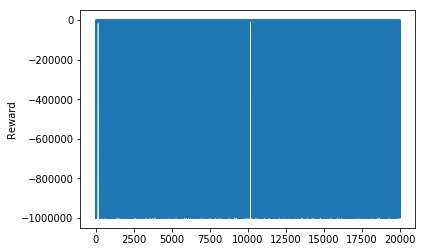

In [11]:
import matplotlib.pyplot as plt
plt.plot(plotrr)
plt.ylabel('Reward')
plt.show()

In [12]:
for x in signals:
    print(x)

24
2
13
12
1
1
1
1
2
3
2
2
3
4
3
3
4
12
4
4
12
13
12
13
13
14
14
14
14
23
23
23
23
24
4
24
3
34
24
34
34
1
14
3
12
2
34
3
1
4
14
3
1
2
3
13
24
1
3
13
1
4
1
24
4
2
3
3
2
1
13
1
1
24
2
3
24
3
1
3
4
1
3
24
4
4
4
2
2
2
24
3
4
1
2
24
13
3
2
4
2
4
1
4
24
13
3
1
3
3
2
1
1
1
3
4
3
4
1
2
2
24
13
2
3
2
4
2
2
3
4
24
3
4
2
4
1
13
1
3
24
2
13
2
1
1
1
2
4
2
13
1
3
24
4
1
2
3
4
1
1
3
3
1
24
1
4
1
1
13
1
4
2
1
4
2
4
3
3
1
2
2
4
1
13
1
4
24
2
24
3
1
24
3
2
1
1
2
13
1
4
3
4
2
2
1
1
2
1
3
3
13
24
2
4
1
4
1
2
1
4
4
1
2
2
2
4
3
3
2
13
3
13
3
3
3
3
1
2
3
1
24
13
1
4
13
13
1
24
4
24
24
13
4
1
1
4
3
23
1
1
4
1
12
2
13
3
2
4
3
24
2
24
3
3
4
4
13
13
14
2
4
24
2
13
2
2
1
2
4
2
1
34
2
1
1
3
4
2
34
13
1
2
13
2
1
2
2
13
4
4
1
3
1
4
13
3
13
24
1
2
4
4
3
2
2
3
1
1
3
4
1
13
4
24
1
2
2
4
1
2
24
2
1
1
34
24
24
24
3
13
2
4
2
3
2
4
2
1
2
4
1
1
2
3
4
4
2
2
4
4
2
4
3
3
2
3
3
1
1
2
1
4
1
2
2
1
3
2
4
13
1
2
4
13
1
2
4
34
1
24
4
3
1
2
12
13
1
2
4
13
1
1
4
13
1
1
2
4
1
2
1
24
1
4
4
4
1
2
13
2
4
3
2
2
4
3
2
2
4
3
24
3
3
1
1
1
4


3
2
1
4
3
2
13
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
23
2
1
4
3
2
1
4
3
2
1
4
12
2
1
4
3
2
1
4
3
23
1
1
3
2
1
4
14
2
1
4
3
2
24
4
3
2
1
4
3
2
1
4
3
1
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
34
34
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
14
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
14
4
3
2
1
4
13
2
1
3
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
2
3
2
1
4
3
24
1
4
3
2
1
4
3
2
1
4
3
2
13
4
3
2
1
4
3
2
1
4
3
4
1
4
3
2
1
3
3
2
1
4
3
2
1
13
3
13
12
4
3
14
1
4
3
2
1
4
3
3
1
4
3
2
1
4
3
24
1
4
3
2
1
4
3
2
1
4
3
2
1
4
13
2
1
2
3
2
1
4
3
2
14
4
4
2
1
4
3
2
1
4
3
2
1
4
3
12
1
4
3
2
1
4
3
2
1
4
3
2
3
4
3
2
1
4
3
2
1
4
34
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
24
2
1
4
3
2
14
4
3
2
1
4
3
2
1
4
3
2
1
4
23
2
1
4
3
2
1
4
3
2
1
4
3
34
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
14
24
4
3
2
1
2
3
2
1
4
3
2
1
1
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
4
2


2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
23
2
1
4
3
2
1
4
3
2
1
4
3
2
1
12
3
2
1
4
3
34
1
4
3
2
1
4
4
2
23
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
14
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
34
4
3
2
1
2
3
2
1
4
14
2
1
4
3
2
1
4
3
3
1
4
3
2
1
14
3
2
1
4
13
2
1
4
3
2
1
4
1
2
1
4
3
2
12
4
3
2
1
4
3
2
1
4
3
2
1
4
3
12
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
14
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
14
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
12
2
1
14
3
2
34
4
3
2
1
4
3
13
1
4
3
2
1
4
3
2
3
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
13
2
1
23
3
2
1
4
3
34
2
4
4
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
3
3
2
1
4
3
2
13
4
3
2
24
4
3
2
1
13
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
4
34
1
4
3
2
1
4
3
2
1
24
3
2
1
4
34
2
1
4
3
2
13
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
13
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
4
3
2
1
24
3
4
1
14
3
2
1
4
3
2
1
4
3
2
1
4
3
2
4
4
3
2
1
4
3
2
1
4
3
2


2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
3
3
4
1
2
3
4
1
2
13
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
12
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
13
3
4
1
2
3
4
1
2
3
4
13
2
3
4
1
2
3
4
1
12
3
4
1
2
3
4
1
2
3
4
1
2
3
4
3
2
3
4
1
2
3
24
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
1
1
2
3
4
1
2
3
4
1
2
3
4
1
34
3
4
1
2
3
4
1
2
3
4
24
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
14
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
4
4
1
2
3
4
24
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
34
4
1
2
13
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
3
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
12
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
4
3
4
1
2
3
13
1
2
3
4
1
14
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
4
4
1
2
3
4
1
2
3
4
34
2
3
4
1
2
3
4
1
2
3
4
1
4
3
34
12
2
3
13
1
2
3
4
1
2
3
4
1
2
3
4
12
34
3
4
1
2
3
4
23
2
3
4
1
2
24
4
1
2
2
4
1
2
3
12
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1


1
4
4
1
1
4
4
1
3
1
1
2
2
2
3
4
12
2
3
2
2
13
3
2
4
2
4
2
4
2
4
2
1
4
3
24
13
13
3
24
2
24
3
3
13
13
3
13
24
2
1
24
2
2
1
24
4
1
4
4
3
3
1
3
2
4
2
1
1
4
2
1
13
4
13
1
1
4
3
1
2
2
2
3
3
2
2
3
2
24
1
1
1
3
2
1
3
13
13
1
24
3
1
2
4
3
1
2
1
3
1
2
1
3
1
2
4
34
24
2
4
4
3
2
13
2
1
2
3
2
1
2
1
3
24
2
13
1
2
2
3
1
3
2
4
2
2
24
13
2
2
3
4
2
2
3
4
2
2
3
2
4
4
2
3
2
1
4
13
1
1
4
4
1
1
4
13
13
3
1
1
3
2
3
4
1
1
4
23
1
1
4
4
4
24
13
24
1
2
3
24
1
2
4
3
1
2
3
2
1
2
3
13
1
2
3
2
24
13
1
24
1
13
3
24
1
13
3
24
1
13
3
3
1
13
13
24
1
2
3
3
1
2
3
3
1
2
3
24
1
4
3
4
1
4
3
4
1
4
3
3
1
2
3
2
2
2
3
2
2
2
3
4
4
1
4
24
13
1
4
1
3
1
4
1
3
1
4
3
24
4
24
2
24
4
4
4
1
1
24
1
13
12
3
2
2
3
3
2
2
3
3
13
2
13
2
24
4
14
1
2
4
4
1
2
4
24
1
3
3
4
14
3
3
4
4
3
3
2
1
4
4
4
1
2
4
4
1
2
4
4
1
4
1
1
4
1
4
3
1
3
3
2
3
2
24
2
3
2
2
2
2
2
13
3
14
3
24
4
3
4
3
4
3
13
2
3
1
4
2
3
1
4
2
3
1
4
2
3
4
4
2
14
1
4
2
3
1
4
2
3
1
4
2
3
1
4
2
3
1
4
2
3
1
4
2
3
1
4
2
3
1
4
2
3
1
4
2
3
1
4
2
3
1
4
2
12
1
4
2
3
1
4
2
3
1
3
13
3
34
4
2
24
1
4